Epoch 0/10, Batch 0/31
Epoch 0/10, Batch 1/31
Epoch 0/10, Batch 2/31
Epoch 0/10, Batch 3/31
Epoch 0/10, Batch 4/31
Epoch 0/10, Batch 5/31
Epoch 0/10, Batch 6/31
Epoch 0/10, Batch 7/31
Epoch 0/10, Batch 8/31
Epoch 0/10, Batch 9/31
Epoch 0/10, Batch 10/31
Epoch 0/10, Batch 11/31
Epoch 0/10, Batch 12/31
Epoch 0/10, Batch 13/31
Epoch 0/10, Batch 14/31
Epoch 0/10, Batch 15/31
Epoch 0/10, Batch 16/31
Epoch 0/10, Batch 17/31
Epoch 0/10, Batch 18/31
Epoch 0/10, Batch 19/31
Epoch 0/10, Batch 20/31
Epoch 0/10, Batch 21/31
Epoch 0/10, Batch 22/31
Epoch 0/10, Batch 23/31
Epoch 0/10, Batch 24/31
Epoch 0/10, Batch 25/31
Epoch 0/10, Batch 26/31
Epoch 0/10, Batch 27/31
Epoch 0/10, Batch 28/31
Epoch 0/10, Batch 29/31
Epoch 0/10, Batch 30/31
Epoch 1/10, Batch 0/31
Epoch 1/10, Batch 1/31
Epoch 1/10, Batch 2/31
Epoch 1/10, Batch 3/31
Epoch 1/10, Batch 4/31
Epoch 1/10, Batch 5/31
Epoch 1/10, Batch 6/31
Epoch 1/10, Batch 7/31
Epoch 1/10, Batch 8/31
Epoch 1/10, Batch 9/31
Epoch 1/10, Batch 10/31
Epoch 1/10, 

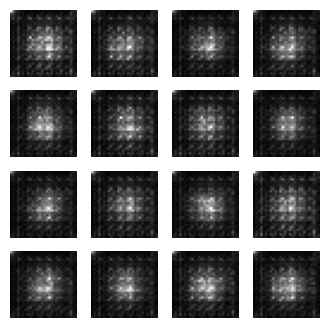

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
# Load the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images [:1000] - 127.5) / 127.5
train_images = np.expand_dims(train_images,axis=-1)

# Normalize the images to [-1, 1]
train_images = train_images / 255.0
train_images = (train_images - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Create the generator
generator = make_generator_model()

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create the discriminator
discriminator = make_discriminator_model()

# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop
EPOCHS = 10
BATCH_SIZE = 32
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for i in range(len(dataset)//BATCH_SIZE):
            train_step(dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
            print(f"Epoch {epoch}/{epochs}, Batch {i}/{len(dataset)//BATCH_SIZE}")

# Train the GAN
train(train_images, EPOCHS)

# Generate and save images
predictions = generator(seed, training=False)
plt.figure(figsize=(4,4))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()